# NYU CUSP: Applied Data Science 2019, Network Analysis module, session 2
# Routing, betweenness, closeness centrality

Consider a network (non-weighted) $(N,E)$ where
$$
N=\{a_i, i=1..n\},\ E=\{(a_j, b_j)\}
$$
Start from an undirected case. Denote adjacency matrix of this network as $A$.


## Betweenness centrality

Sometimes, especially when considering resilience/vulnerability of different social or infrastructural networks, including road infrastructure, it us also relevant to understand how important the node is for the internal network topology - specifically for the shortest-path routing. In order to address this idea betweenness centrality is introduced for connected directed or undirected networks in the following way: 
$$
{\rm betweenness\_centrality}(a)=\sum_{b,c\in N,b\neq a\neq c}\frac{|g_{b,c}: a\in g_{b,c}|}{|g_{b,c}|},
$$
where $g_{b,c}$ denotes the set of all shortest or geodesic paths between $b$ and $c$. Although we typically do not care about the absolute, but rather relative values of centrality, in case we want to have the above value normalized between 0 and 1 we can introduce a normalization factor of $\frac{1}{(n-1)(n-2)}$ according to the maximal possible number of paths going through $a$. The maximal possible normalized value of $1$ is reached for the central point in a star-like network topology.

## Closeness centrality

Another concept of centrality related to the network routing is closeness centrality, which represents how close the node is to all other nodes, i.e. how short the corresponding geodesic paths are:
$$
{\rm closeness\_centrality}(a)=\frac{1}{\sum_{b\in N} d_{a,b}},
$$
or in the normalized form:
$$
{\rm closeness\_centrality}(a)=\frac{n-1}{\sum_{b\in N, b\neq a}d_{a,b}},
$$
where $d_{a,b}$ denotes the distance (length of the geogesic path) from $a$ to $b$. The second version is always normalized between $0$ and $1$ and the maximal value of $1$ is acheived if node $a$ is directly connected to all other nodes in the network. 

Notice that this definition also works pretty well for both - directed and undirected networks, however in case of undirected networks it might be also relevant to consider the incoming version of closeness
$$
{\rm closeness\_centrality}(a)=\frac{n-1}{\sum_{b\in N, b\neq a}d_{b,a}}
$$
showing how close $a$ is to other nodes rather than how close other nodes are to $a$.

In [1]:
#add necessary libraries
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%pylab inline 
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


# NYC Subway Network

In [2]:
#station list
Stations = pd.read_csv( 'data/nodes.csv' , index_col=None, header=0 )
Stations.head()

,name,id,boro,lat,long,lines
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G
1,21 St,G24,Q,40.744065,-73.949724,G
2,Court Sq,G22,Q,40.746554,-73.943832,G
3,36 St,G20,Q,40.752039,-73.928781,M R
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R


In [3]:
#connection list
Links = pd.read_csv( 'data/edges.csv' , index_col=None, header=0 )
Links.head()

,origin,dest
0,G26,G24
1,G26,G28
2,G24,G26
3,G24,G22
4,G22,G24


In [4]:
#number of subway stations
size(Stations,0)

498

In [5]:
#number of subway connections
size(Links,0)

1848

In [6]:
#create a dictionary of subway stations by name and location
StPos={Stations.id[c]:(Stations.long[c],Stations.lat[c]) for c in Stations.index}
StName={Stations.id[c]:Stations.name[c] for c in Stations.index}

In [7]:
#creare a directed graph subway network
NYCSubway=nx.DiGraph()
for i in Links.index:
   NYCSubway.add_edge(Links.origin[i],Links.dest[i])   

/Users/stanislav/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


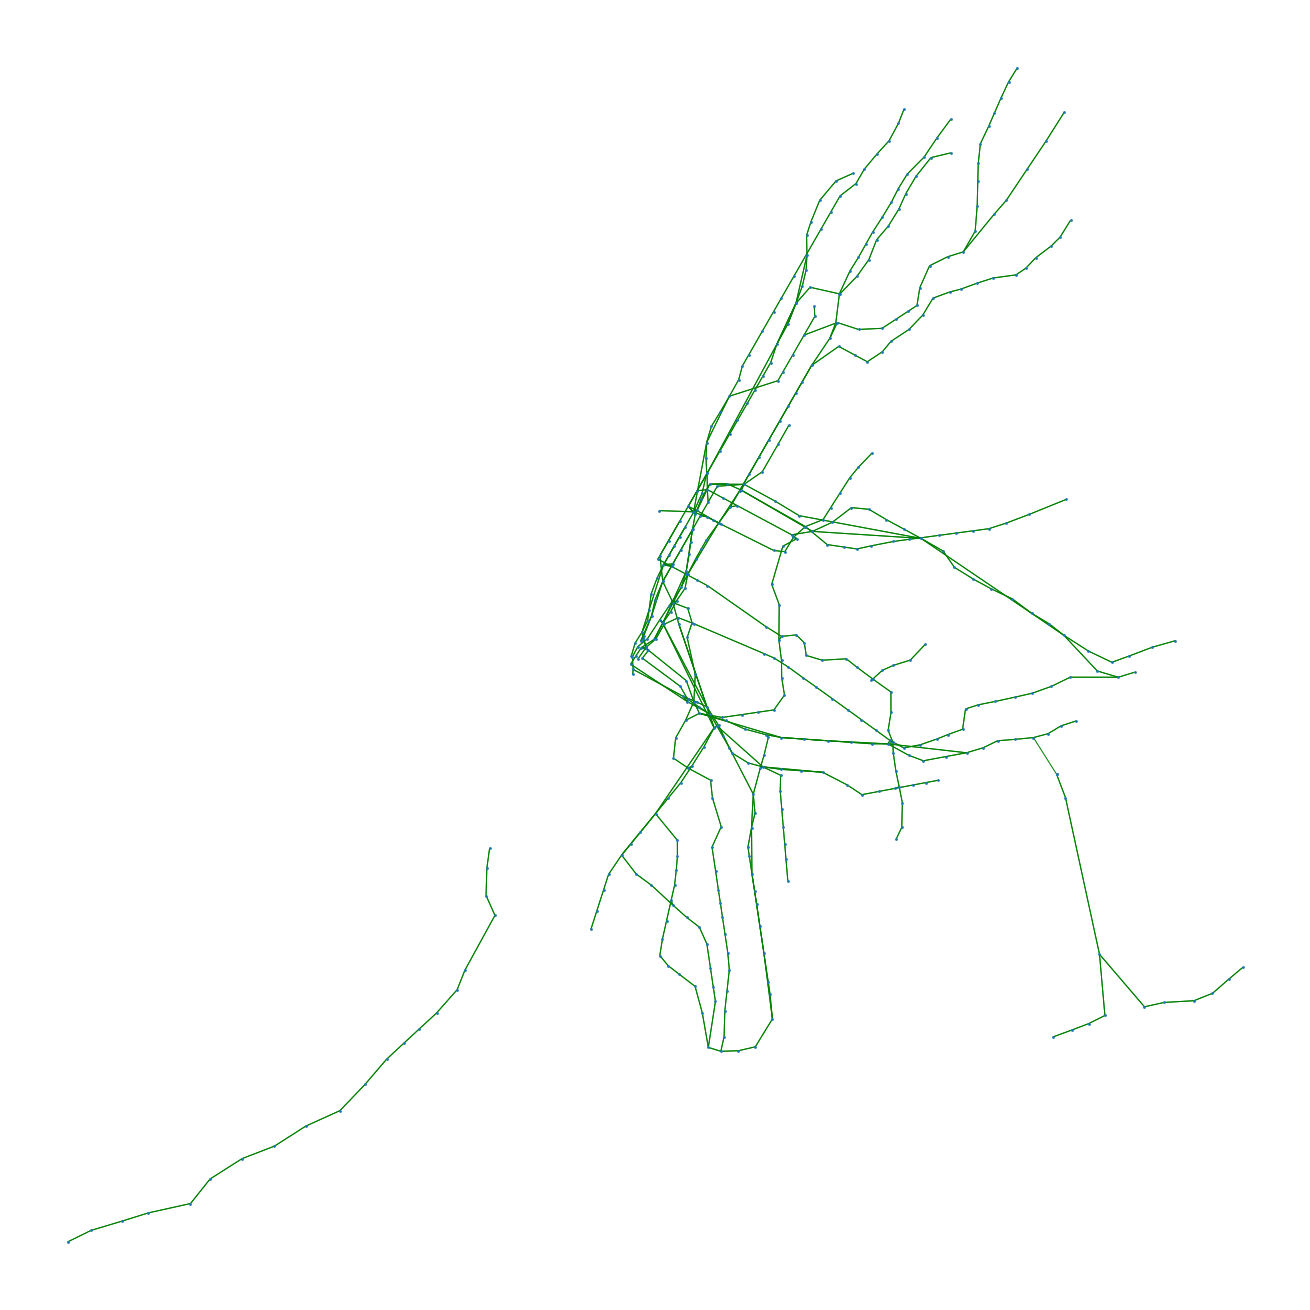

In [8]:
#visualize the subway newtork
plt.figure(figsize = (18,18))
nx.draw(NYCSubway,pos=StPos,with_labels=False,arrows=False,node_size=3,width=1,edge_color='green')

In [9]:
#find connected components
nx.number_weakly_connected_components(NYCSubway)

2

In [10]:
#see there sizes; further we'll deal with the largest (NYC besides Staten Island)
CC=sorted(nx.weakly_connected_components(NYCSubway), key=len, reverse=True)

In [11]:
len(CC[0])

473

#### Task 1a. Find shortest path between Jay Str.-Metrotech (A41) and Junction Blvd, Queens (707)

In [12]:
path1=nx.shortest_path(NYCSubway,'A41','707')

In [13]:
path1

['A41',
 'A40',
 'A38',
 '418',
 '640',
 '635',
 '631',
 '629',
 'R11',
 'G21',
 'G14',
 '710',
 '709',
 '708',
 '707']

In [14]:
len(path1)

15

In [15]:
#auxiliary function - visualize path on the map
def visualize_path(path):
    plt.figure(figsize = (15,18))
    nx.draw(NYCSubway,pos=StPos,with_labels=False,arrows=False,node_size=1,width=1,edge_color='green')
    x=[StPos[v][0] for v in path]
    y=[StPos[v][1] for v in path]
    plt.plot(x,y,'ro-')
    plt.plot([x[0],x[-1]],[y[0],y[-1]],'bs',markersize=10)

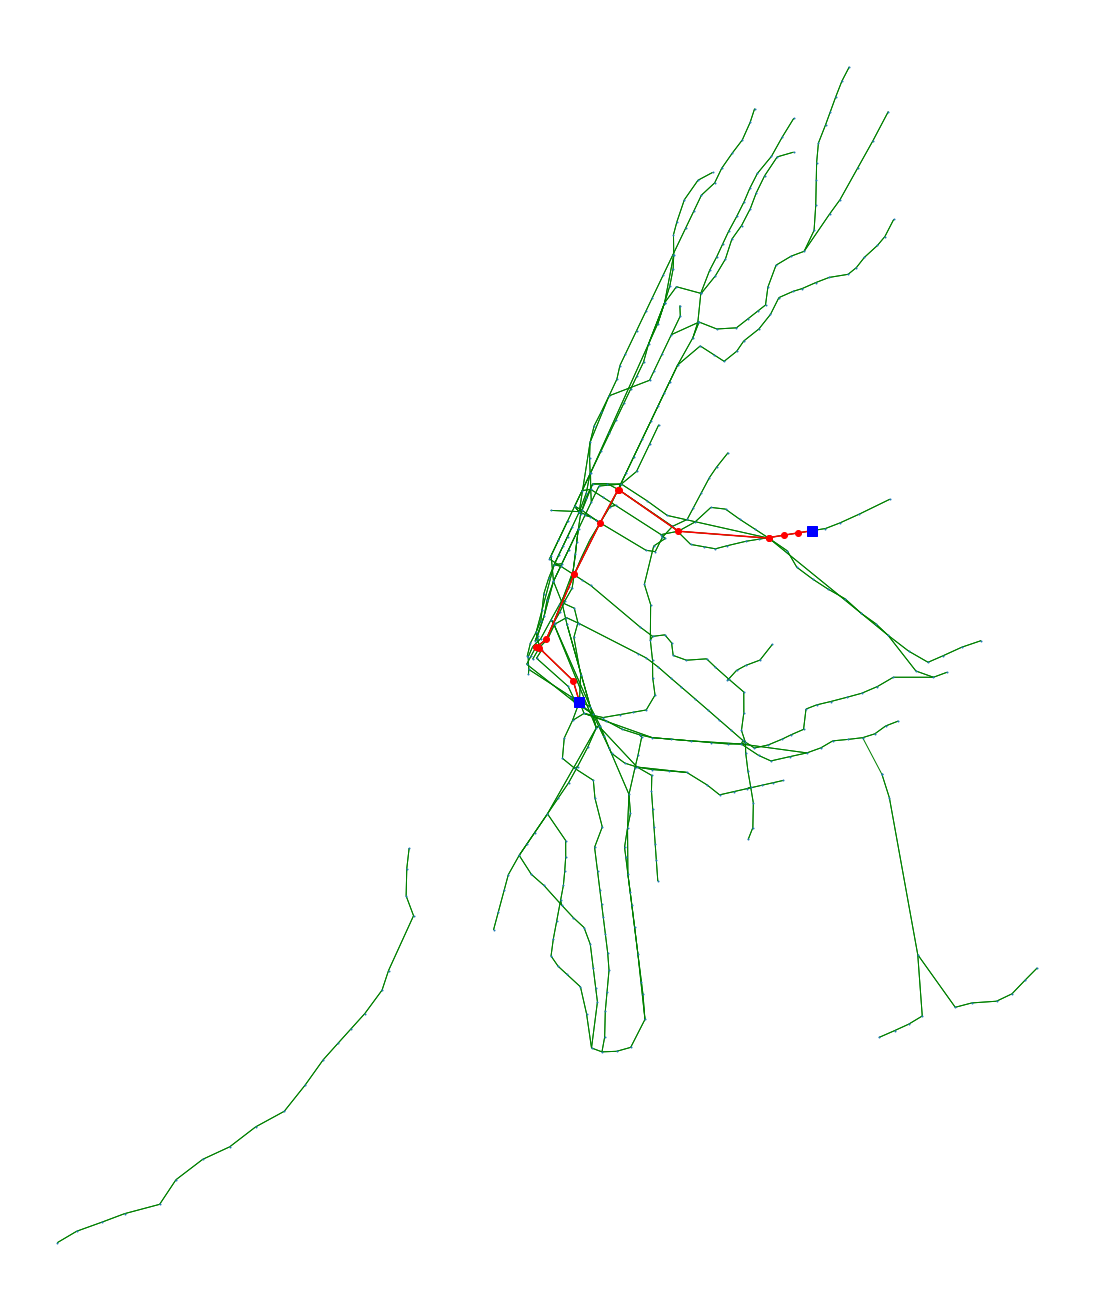

In [16]:
visualize_path(path1)

#### Task 1b. Find shortest path between Jay Str.-Metrotech (A41) and Junction Blvd, Queens (707) in terms of travel distance 

In [17]:
#auxiliary function: geodesic distance on the Earth surface between two lat-long points
from math import sin, cos, sqrt, atan2, radians
def geodist(lon1,lat1,lon2,lat2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)  
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [18]:
#compute and assing lengths the all the edges
nx.set_edge_attributes(NYCSubway, 'dist', 0)
for e in NYCSubway.edges():
   NYCSubway[e[0]][e[1]]['dist']=geodist(StPos[e[0]][0],StPos[e[0]][1],StPos[e[1]][0],StPos[e[1]][1])

In [19]:
path2=nx.shortest_path(NYCSubway,'A41','707',weight='dist')

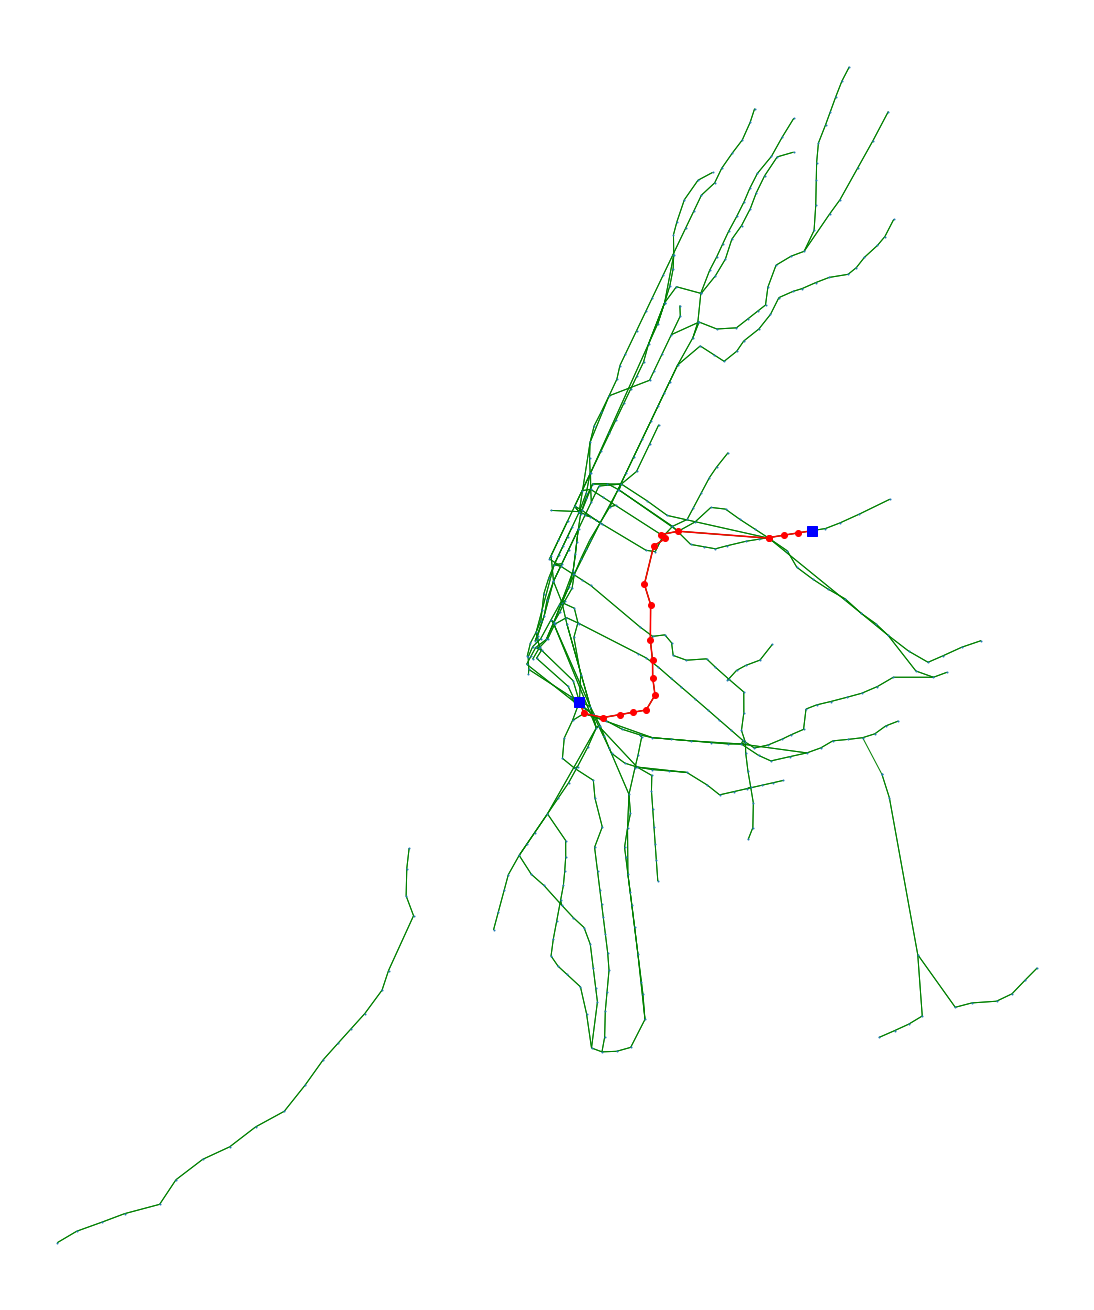

In [20]:
visualize_path(path2)

#### Task 2. Find the diameter of the graph in terms of distance and number of stations and output its value, beginning/end of the longest path, visualize the paths

In [21]:
#compute travel times to different locations
allpaths=dict(nx.shortest_path_length(NYCSubway))
allpathsD=dict(nx.shortest_path_length(NYCSubway,weight='dist'))

In [22]:
diameter=0; i0=0; j0=0;
for i in allpaths.items():
  for j in i[1].items():
    if j[1]>diameter:
      diameter=j[1]
      i0=i[0]
      j0=j[0]  
print('{0} - {1} : {2}'.format(StName[i0],StName[j0],diameter))

Far Rockaway - Mott Av - Wakefield - 241 St : 49


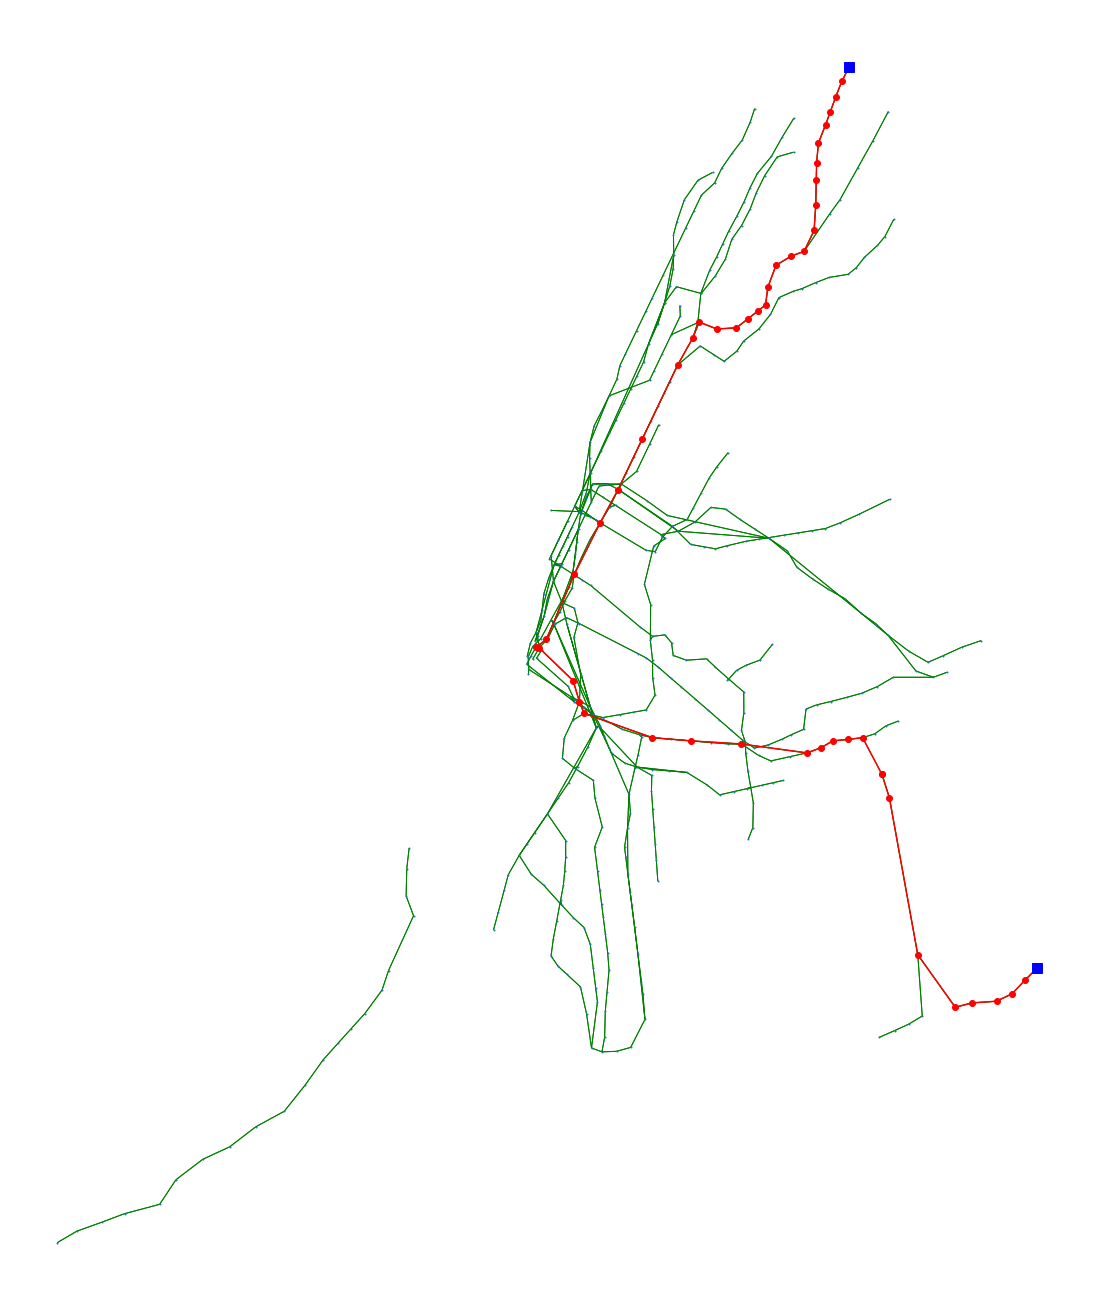

In [23]:
Lpath=nx.shortest_path(NYCSubway,i0,j0)
visualize_path(Lpath)

In [24]:
diameter=0; i0=0; j0=0;
for i in allpathsD.items():
  for j in i[1].items():
    if j[1]>diameter:
      diameter=j[1]
      i0=i[0]
      j0=j[0]  
print('{0} - {1} : {2}'.format(StName[i0],StName[j0],diameter))

Far Rockaway - Mott Av - Wakefield - 241 St : 54.962094658175005


#### Task 3. Compute degree, pagerank, betweenness and closeness centrality for NYC Subway network, list top 10 nodes by each. Visualize the above top 10 nodes by each metric

In [25]:
#output top tn centrality scores, given the dictionary d
def topdict(d,tn):
    ind=sorted(d, key=d.get, reverse=True)
    for i in range(0,tn):
       print('{0}|{1} - {2} : {3}'.format(i+1,ind[i],StName[ind[i]],d[ind[i]]))
    return ind

In [26]:
mc1=dict(nx.degree(NYCSubway))
ind1=topdict(mc1,10)

1|R16 - Times Sq - 42 St : 14
2|A27 - 42 St - Port Authority Bus Terminal : 14
3|127 - Times Sq - 42 St : 14
4|R31 - Atlantic Av - Barclays Ctr : 14
5|G14 - Jackson Hts - Roosevelt Av : 12
6|A51 - Broadway Jct : 12
7|725 - Times Sq - 42 St : 12
8|631 - Grand Central - 42 St : 12
9|635 - 14 St - Union Sq : 12
10|B08 - Lexington Av/63 St : 12


Clearly the degree rankings do not give really distrinctive values and reflect just the local topology of the infrastructural network

In [27]:
mc2 = nx.pagerank(NYCSubway,0.85)
ind2=topdict(mc2,10)

1|G14 - Jackson Hts - Roosevelt Av : 0.0042911876301375855
2|A51 - Broadway Jct : 0.004240855133119337
3|239 - Franklin Av : 0.004163060639263965
4|R31 - Atlantic Av - Barclays Ctr : 0.00398003495263838
5|B08 - Lexington Av/63 St : 0.003829477846803269
6|132 - 14 St : 0.003814653461670501
7|127 - Times Sq - 42 St : 0.003770399542623098
8|R16 - Times Sq - 42 St : 0.003643932546934742
9|629 - 59 St : 0.0036294956162624473
10|A27 - 42 St - Port Authority Bus Terminal : 0.003624071809766451


So the rankings happen to be completely distinctive now. Now visualize the top 10 stations in terms of pagerank.

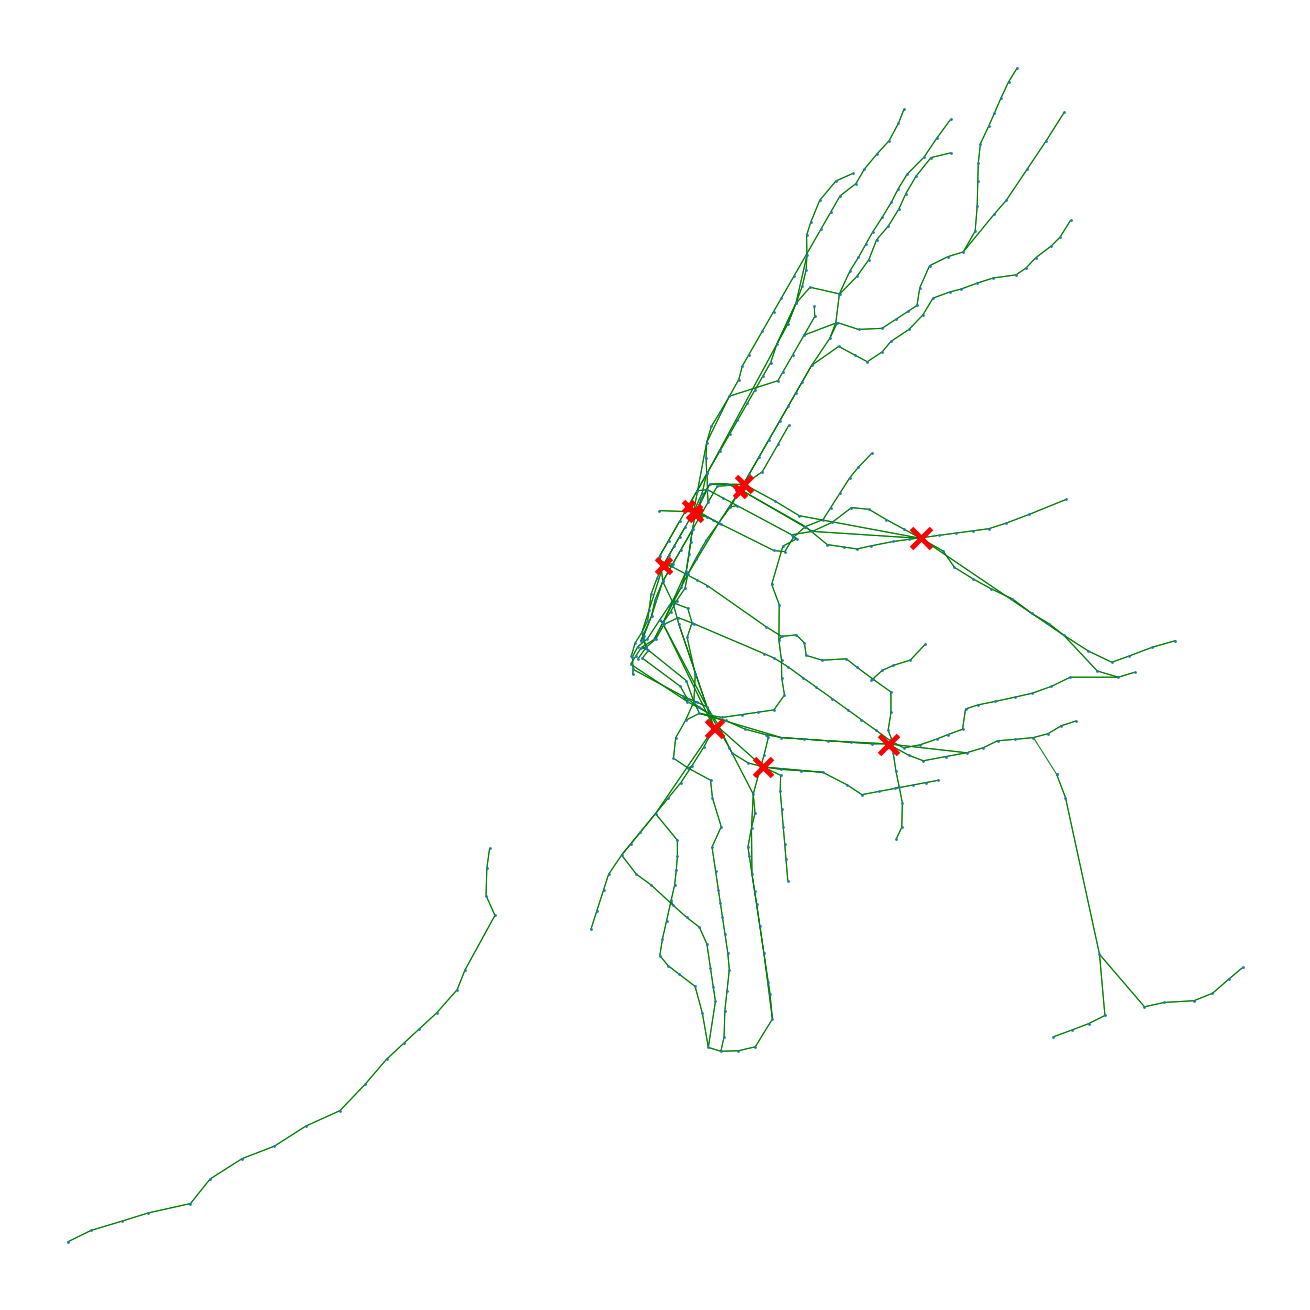

In [28]:
plt.figure(figsize = (18,18))
nx.draw(NYCSubway,pos=StPos,with_labels=False,arrows=False,node_size=3,width=1,edge_color='green')
for i in range(0,10):
  plt.plot(StPos[ind2[i]][0],StPos[ind2[i]][1],'xr',markersize=20-i,markeredgewidth=5)

In [29]:
mc3 = nx.betweenness_centrality(NYCSubway)
ind3=topdict(mc3,10)

1|Q01 - Canal St : 0.3079728700189545
2|R20 - 14 St - Union Sq : 0.3066409614707738
3|629 - 59 St : 0.27912683117439946
4|631 - Grand Central - 42 St : 0.25803092804774846
5|635 - 14 St - Union Sq : 0.2560377812635025
6|R31 - Atlantic Av - Barclays Ctr : 0.2392478997188843
7|621 - 125 St : 0.19306583122073165
8|626 - 86 St : 0.1890734427505319
9|R16 - Times Sq - 42 St : 0.14292663038828904
10|A41 - Jay St - MetroTech : 0.1365341160293671


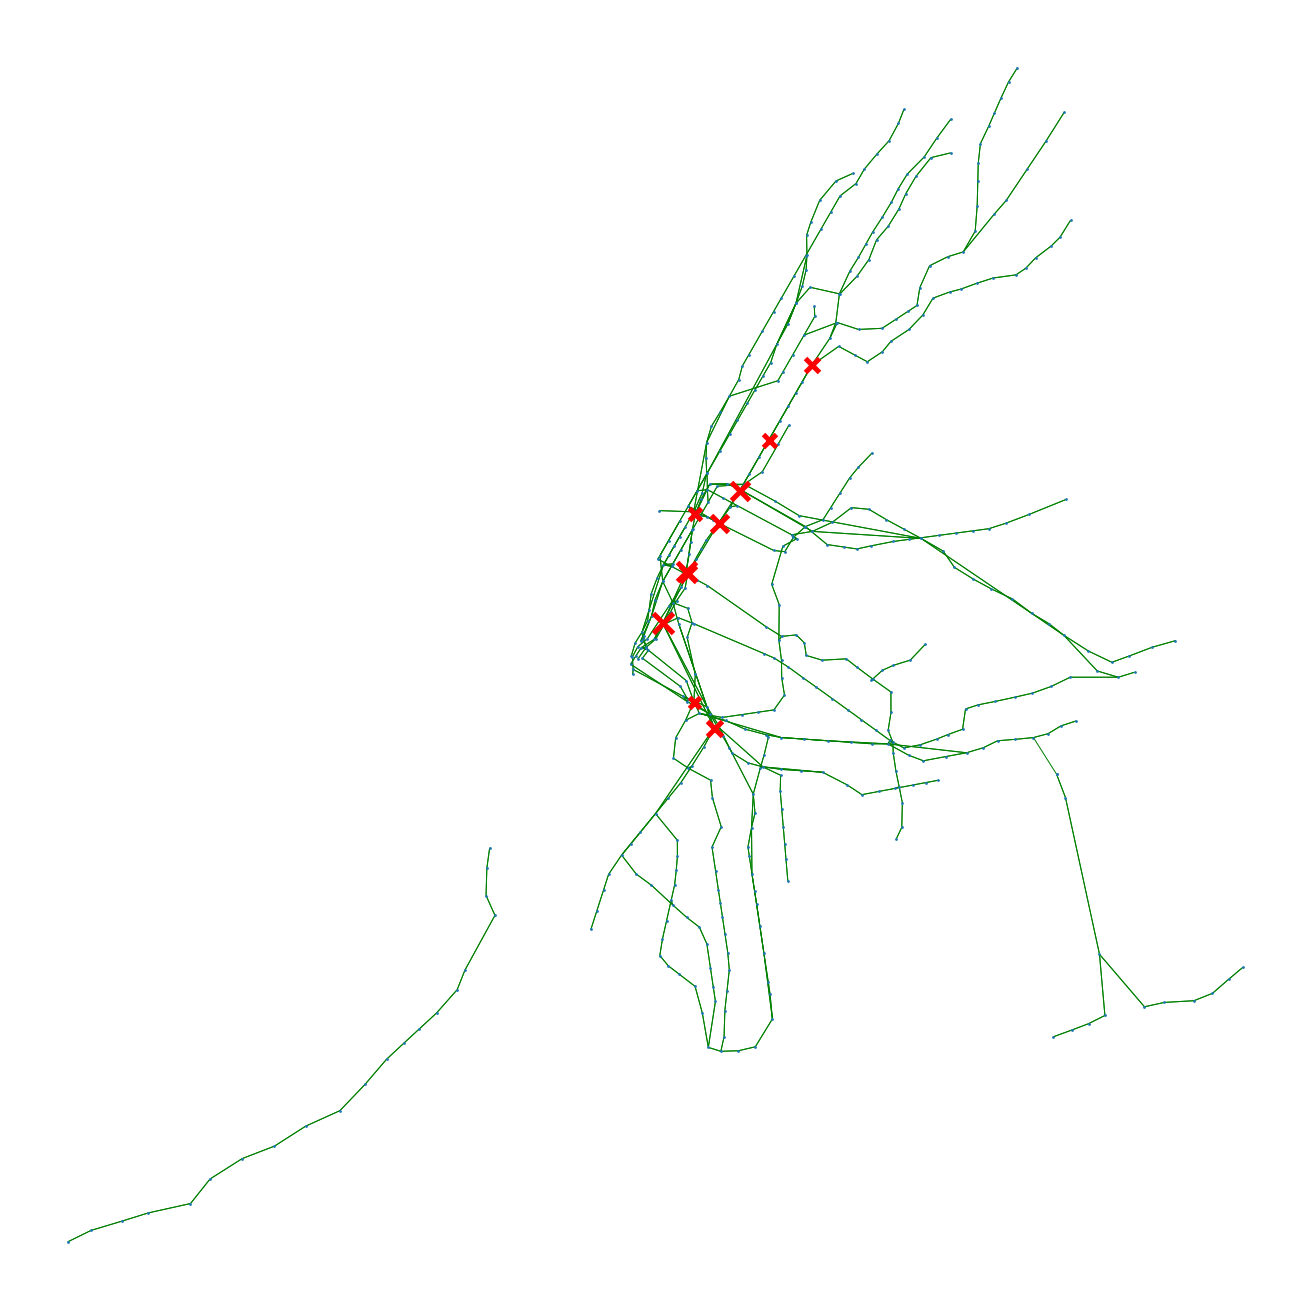

In [30]:
plt.figure(figsize = (18,18))
nx.draw(NYCSubway,pos=StPos,with_labels=False,arrows=False,node_size=3,width=1,edge_color='green')
for i in range(0,10):
  plt.plot(StPos[ind3[i]][0],StPos[ind3[i]][1],'xr',markersize=20-i,markeredgewidth=5)

In [31]:
mc4 = nx.closeness_centrality(NYCSubway)
ind4=topdict(mc4,10)

1|R20 - 14 St - Union Sq : 0.11064998122589911
2|Q01 - Canal St : 0.10883779463549421
3|635 - 14 St - Union Sq : 0.1084199912011929
4|631 - Grand Central - 42 St : 0.10744044777141513
5|R17 - 34 St - Herald Sq : 0.10514065223977943
6|L03 - Union Sq - 14 St : 0.1050184809032238
7|R16 - Times Sq - 42 St : 0.10467790672378317
8|R30 - DeKalb Av : 0.1046536645036063
9|R31 - Atlantic Av - Barclays Ctr : 0.10450844665276873
10|640 - Brooklyn Bridge - City Hall : 0.10414715909808067


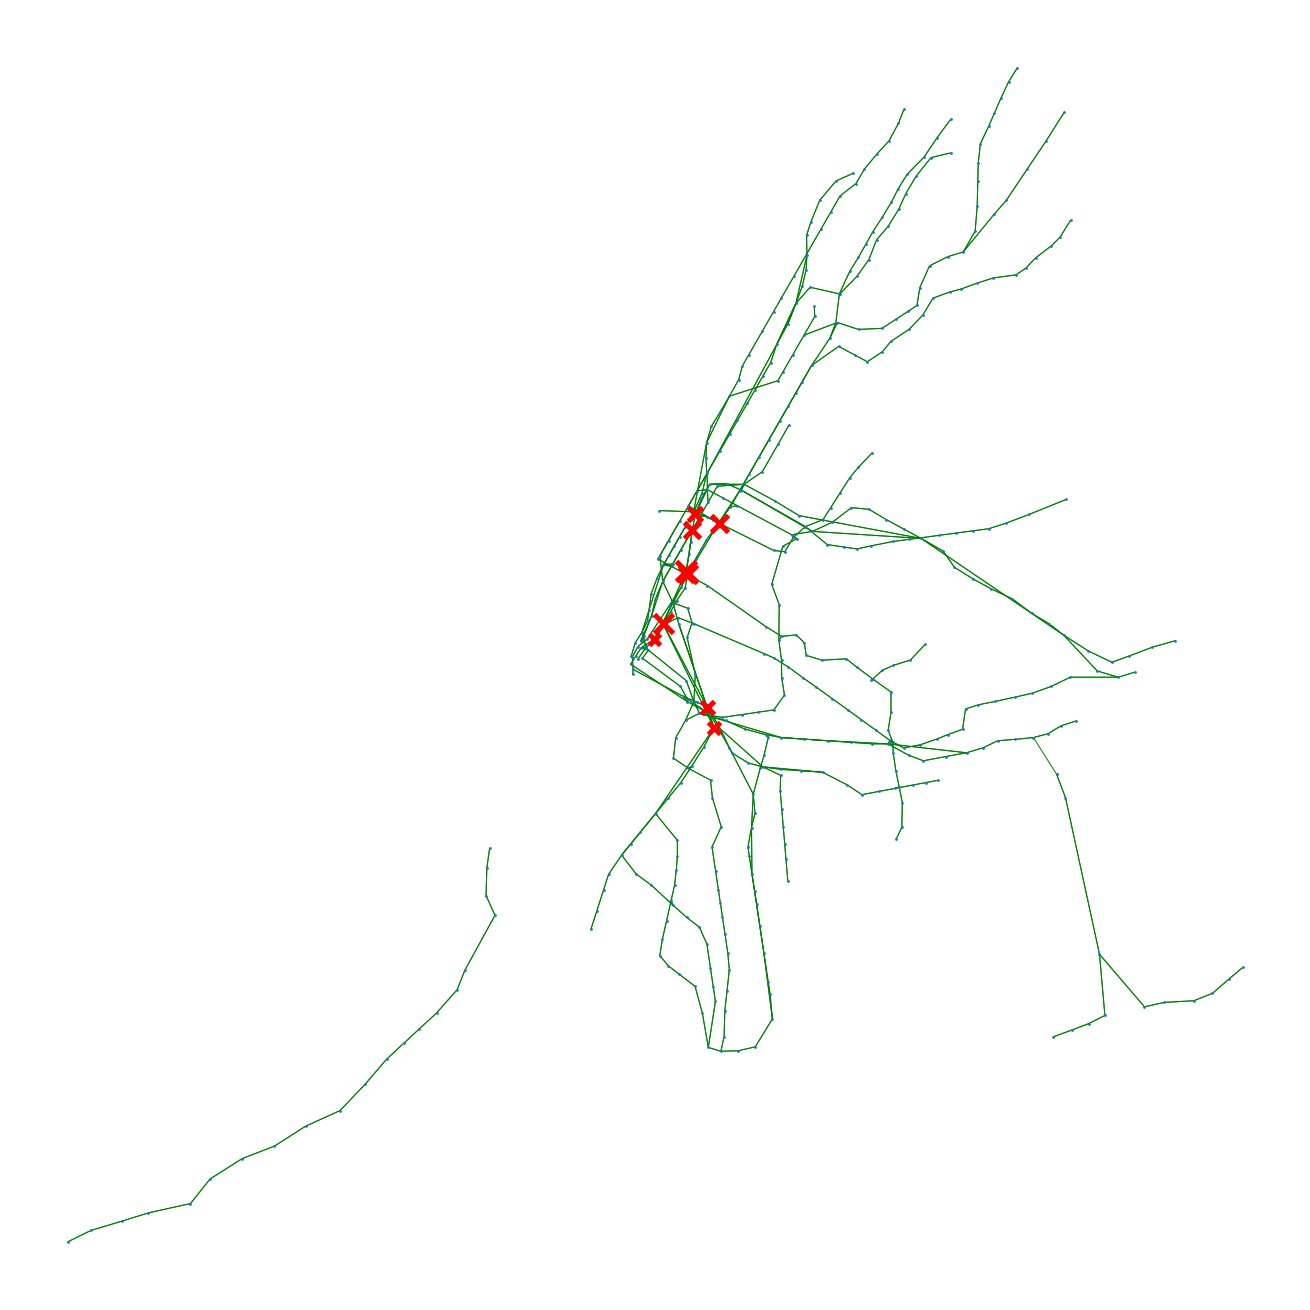

In [32]:
plt.figure(figsize = (18,18))
nx.draw(NYCSubway,pos=StPos,with_labels=False,arrows=False,node_size=3,width=1,edge_color='green')
for i in range(0,10):
  plt.plot(StPos[ind4[i]][0],StPos[ind4[i]][1],'xr',markersize=20-i,markeredgewidth=5)

#### Task 4 (World airports). 
a) Find connected components, report their number and the sizes.  

b) In the largest connected component find top 10 airports by each centrality metric (degree, betweenneass, closeness, pagerank). 

c) Find average network distance of the shortest path between all pairs of the airports from the largest connected component. 

d) Find average distance among the top 100 airports by degree, betweenness, closeness, pagerank.